# Imports

In [9]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [10]:
bpic2012 = {
    "test": "C://Users//nikol//MT-repo//data//bpic2012_a//bpic2012_a_TEST.csv",
        "gen_cvae": "C://Users//nikol//MT-repo//logs//eval//runs//2025-10-03_17-54-49//baseline_cvae_rerun_test//generated", 
        "gen_flow": "C://Users//nikol//MT-repo//logs//eval//runs//2025-10-15_14-03-31//baseline_cvae_rerun_test//generated",
        "gen_flow_beam": "C://Users//nikol//MT-repo//logs//eval//runs//2025-10-15_19-20-58//baseline_cvae_rerun_test//generated"
        }

sepsis = {
    "test": "C://Users//nikol//MT-repo//data//sepsis//sepsis_TEST.csv",
    "gen_cvae" : "C://Users//nikol//MT-repo//logs//train//runs//2025-09-28_18-52-04//baseline_cvae_rerun_test//generated",
    "gen_flow": "C://Users//nikol//MT-repo//logs//eval//runs//2025-09-25_10-48-59//baseline_cvae_rerun_test//generated",
    "gen_flow_beam": "C://Users//nikol//MT-repo//logs//train//runs//2025-09-26_20-07-38//baseline_cvae_rerun_test//generated"
}

emergency = {
    "test": "C://Users//nikol//MT-repo//data//emergency_ORT//emergency_ORT_TEST.csv",
    "gen_cvae": "C://Users//nikol//MT-repo//logs//train//runs//2025-11-15_21-10-43//baseline_cvae_rerun_test//generated",
    "gen_flow": "C://Users//nikol//MT-repo//logs//eval//runs//2025-11-15_17-32-17//baseline_cvae_rerun_test//generated",
    "gen_flow_beam": "C://Users//nikol//MT-repo//logs//train//runs//2025-11-14_21-18-42//baseline_cvae_rerun_test//generated"
}

dataset_name = 'bpic2012'  # Options: 'bpic2012', 'sepsis', 'emergency'

data = bpic2012  # Options: bpic2012, sepsis, emergency

In [11]:
# ---------- Helpers ----------

def _unify_schema(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if {'case:concept:name', 'concept:name', 'org:resource'}.issubset(df.columns):
        pass
    elif {'Case ID', 'Activity', 'Resource'}.issubset(df.columns):
        df = df.rename(columns={
            'Case ID': 'case:concept:name',
            'Activity': 'concept:name',
            'Resource': 'org:resource',
        })
    else:
        raise ValueError("Missing required columns: expected either ['case:concept:name','concept:name','org:resource'] or ['Case ID','Activity','Resource']")
    if 'time:timestamp' in df.columns:
        df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], errors='coerce')
    else:
        df['time:timestamp'] = pd.NaT
    return df

# Normalize resources similar to log_stats: strip and lower; treat only truly empty tokens as placeholders
# Relaxed placeholder set to avoid dropping legitimate labels like '-' or 'unknown' in some datasets
_RESOURCE_PLACEHOLDERS = {'', 'nan', 'nat', 'none', 'null', 'na', 'n/a'}

def _normalize_resources_series(s: pd.Series) -> pd.Series:
    if s is None:
        return s
    s2 = s.astype(str).str.strip()
    s2_lower = s2.str.lower()
    s2_clean = s2_lower.mask(s2_lower.isin(_RESOURCE_PLACEHOLDERS))
    return s2_clean


def event_log_stats(df: pd.DataFrame, dataset_name: str = "log") -> pd.DataFrame:
    df = _unify_schema(df)
    n_cases = df['case:concept:name'].nunique()
    n_events = len(df)
    n_activities = df['concept:name'].nunique()
    # Resource normalization
    if 'org:resource' in df.columns:
        res_norm = _normalize_resources_series(df['org:resource'])
        n_resources = int(res_norm.dropna().nunique())
        df['__resource_norm__'] = res_norm
    else:
        n_resources = 0
    df_sorted = df.sort_values(['case:concept:name', 'time:timestamp'])
    case_sizes = df_sorted.groupby('case:concept:name').size() if n_cases > 0 else pd.Series(dtype=int)
    if df['time:timestamp'].notna().any() and n_cases > 0:
        first_last = df_sorted.groupby('case:concept:name')['time:timestamp'].agg(['min', 'max'])
        tpt = (first_last['max'] - first_last['min']).dt.total_seconds() / 60.0
    else:
        tpt = pd.Series(dtype=float)
    window_start = df['time:timestamp'].min()
    window_end = df['time:timestamp'].max()
    total_duration_hours = None
    if pd.notna(window_start) and pd.notna(window_end):
        total_duration_hours = float((window_end - window_start).total_seconds() / 3600.0)
    row = dict(
        dataset=dataset_name,
        n_cases=int(n_cases),
        n_variants=int(df_sorted.groupby('case:concept:name')['concept:name'].apply(tuple).nunique() if n_cases > 0 else 0),
        n_activities=int(n_activities),
        n_resources=int(n_resources),
        trace_len_mean=float(case_sizes.mean()) if case_sizes.size else 0.0,
        trace_len_max=int(case_sizes.max()) if case_sizes.size else 0,
        tpt_mean=float(tpt.mean()) if tpt.size else None,  # minutes
        total_duration_hours=total_duration_hours,
    )
    return pd.DataFrame([row])


def _read_test_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Test CSV not found: {path}")
    for sep in [';', ',']:
        try:
            df = pd.read_csv(path, sep=sep)
            return _unify_schema(df)
        except Exception:
            continue
    raise ValueError(f"Failed to read test CSV with delimiters ';' or ',' : {path}")


def _load_train_from_any_model(data_dict: dict):
    for key, folder in data_dict.items():
        if key == 'test':
            continue
        files = sorted(glob.glob(os.path.join(folder, 'train_SPLIT_*.csv')))
        if not files:
            continue
        dfs = []
        for f in files:
            try:
                df = pd.read_csv(f, sep=';')
                dfs.append(_unify_schema(df))
            except Exception:
                continue
        if dfs:
            out = pd.concat(dfs, ignore_index=True)
            print(f"TRAIN loader: {len(files)} train splits -> cases: {out['case:concept:name'].nunique()} events: {len(out)}")
            return out
    return pd.DataFrame(columns=['case:concept:name','concept:name','org:resource','time:timestamp'])


def aggregate_generated_model(folder: str, pattern: str = 'gen*.csv', dataset_name: str = 'GEN'):
    files = sorted(glob.glob(os.path.join(folder, pattern)))
    if not files:
        files = sorted(glob.glob(os.path.join(folder, '*.csv')))
    rows = []
    for f in files:
        try:
            df = pd.read_csv(f, sep=';')
            stats = event_log_stats(df, dataset_name=os.path.splitext(os.path.basename(f))[0])
            rows.append(stats.iloc[0].to_dict())
        except Exception:
            continue
    if not rows:
        return None
    detail_df = pd.DataFrame(rows)
    # Aggregate hours as mean of per-file total duration (fallback 0 if all missing)
    hours_series = detail_df['total_duration_hours'].dropna()
    total_hours = float(hours_series.mean()) if len(hours_series) else 0.0
    avg_row = {
        'dataset': dataset_name,
        'n_cases': float(detail_df['n_cases'].mean()),
        'n_variants': float(detail_df['n_variants'].mean()),
        'n_activities': float(detail_df['n_activities'].mean()),
        'n_resources': float(detail_df['n_resources'].mean()),
        'trace_len_mean': float(detail_df['trace_len_mean'].mean()),
        'trace_len_max': float(detail_df['trace_len_max'].max()),
        'tpt_mean': float(detail_df['tpt_mean'].mean()) if 'tpt_mean' in detail_df and detail_df['tpt_mean'].notna().any() else None,
        'total_duration_hours': total_hours,
    }
    #print(f"Generated aggregation: folder={folder} files={len(detail_df)} avg_cases={avg_row['n_cases']:.1f}")
    return avg_row

# ---------- Build rows ----------
rows = []
if 'test' in data:
    test_df = _read_test_csv(data['test'])
    rows.append(event_log_stats(test_df, 'TEST').iloc[0].to_dict())
train_df = _load_train_from_any_model(data)
if len(train_df):
    rows.append(event_log_stats(train_df, 'TRAIN').iloc[0].to_dict())
for key, folder in data.items():
    if key == 'test':
        continue
    agg = aggregate_generated_model(folder, dataset_name=key)
    if agg:
        rows.append(agg)

summary_source_df = pd.DataFrame(rows)

# ---------- Presentation summary ----------
summary_rows = []
for _, r in summary_source_df.iterrows():
    mean_len = r.get('trace_len_mean')
    tpt_min = r.get('tpt_mean')
    avg_tpt_h = float(tpt_min) / 60.0 if pd.notna(tpt_min) else None
    avg_tpt_days = avg_tpt_h / 24.0 if avg_tpt_h is not None else None
    total_h = r.get('total_duration_hours', 0.0) or 0.0  # ensure not None/NaN
    total_days = total_h / 24.0
    total_years = total_h / (24.0 * 365.0)
    summary_rows.append({
        'Dataset': r['dataset'],
        'Traces': int(round(r['n_cases'])) if pd.notna(r['n_cases']) else None,
        'Variants': int(round(r['n_variants'])) if pd.notna(r['n_variants']) else None,
        'Activities': int(round(r['n_activities'])) if pd.notna(r['n_activities']) else None,
        'Resources': int(round(r['n_resources'])) if pd.notna(r['n_resources']) else None,
        'Avg. trace length': f"{mean_len:.2f}" if mean_len is not None else None,
        'Max trace length': int(round(r['trace_len_max'])) if pd.notna(r['trace_len_max']) else None,
        'Avg. trace cycle time (h)': round(avg_tpt_h, 2) if avg_tpt_h is not None else None,
        'Avg. trace cycle time (days)': round(avg_tpt_days, 2) if avg_tpt_days is not None else None,
        'Total duration (h)': round(total_h, 2),
        'Total duration (days)': round(total_days, 2),
        'Total duration (years)': round(total_years, 4),
    })
summary_df = pd.DataFrame(summary_rows, columns=[
    'Dataset','Traces','Variants','Activities','Resources','Avg. trace length','Max trace length','Avg. trace cycle time (h)','Avg. trace cycle time (days)','Total duration (h)','Total duration (days)','Total duration (years)'
])

# Save summary only into nested folder "gen logs stats"
out_dir = os.path.abspath(os.path.join('..', 'output')) if os.path.basename(os.getcwd()) == 'notebooks' else os.path.join('output')
stats_dir = os.path.join(out_dir, 'gen logs stats')
os.makedirs(stats_dir, exist_ok=True)
summary_path = os.path.join(stats_dir, f'gen_log_stats_{dataset_name}.csv')
summary_df.to_csv(summary_path, index=False)
print(f"Saved summary stats to: {summary_path}")

summary_df

C:\Users\nikol\AppData\Local\Temp\ipykernel_15352\396579610.py:94: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=';')


TRAIN loader: 3 train splits -> cases: 2811 events: 112683
Saved summary stats to: c:\Users\nikol\MT-repo\output\gen logs stats\gen_log_stats_bpic2012.csv


,Dataset,Traces,Variants,Activities,Resources,Avg. trace length,Max trace length,Avg. trace cycle time (h),Avg. trace cycle time (days),Total duration (h),Total duration (days),Total duration (years)
0,TEST,937,864,36,48,38.15,127,368.20,15.34,1127.59,46.98,0.1287
1,TRAIN,2811,2374,36,59,40.09,175,464.41,19.35,3560.61,148.36,0.4065
2,gen_cvae,937,918,32,48,38.92,90,320.67,13.36,2344.76,97.70,0.2677
3,gen_flow,937,901,36,63,33.12,100,344.07,14.34,3691.41,153.81,0.4214
4,gen_flow_beam,937,926,36,63,30.18,100,339.71,14.15,1612.32,67.18,0.1841


Activities NOT generated by gen_cvae: 4
['W_Beoordelen fraude-COMPLETE', 'W_Beoordelen fraude-SCHEDULE', 'W_Beoordelen fraude-START', 'W_Wijzigen contractgegevens-SCHEDULE']
Saved activity frequency comparison (percent) to: c:\Users\nikol\MT-repo\output\bpic2012\activity_frequency_bpic2012_hbar_pct.pdf


,TRAIN,gen_cvae,gen_flow,gen_flow_beam
W_Nabellen offertes-COMPLETE,12.247633,11.904834,13.010538,14.409540
W_Nabellen offertes-START,11.911291,11.291946,12.941575,13.702254
W_Completeren aanvraag-START,5.953871,6.178514,6.868938,5.726188
W_Completeren aanvraag-COMPLETE,5.953871,5.322664,6.753891,6.120854
W_Nabellen incomplete dossiers-COMPLETE,5.876663,6.715168,2.801070,2.542340
W_Nabellen incomplete dossiers-START,5.872226,7.113339,2.824595,2.394163
W_Valideren aanvraag-COMPLETE,3.896772,4.970014,3.132996,3.233358
W_Valideren aanvraag-START,3.894110,5.952828,3.169733,3.133631
O_CREATED-COMPLETE,3.416664,2.942410,3.641520,4.174049
O_SENT-COMPLETE,3.416664,2.930893,3.635075,4.177939


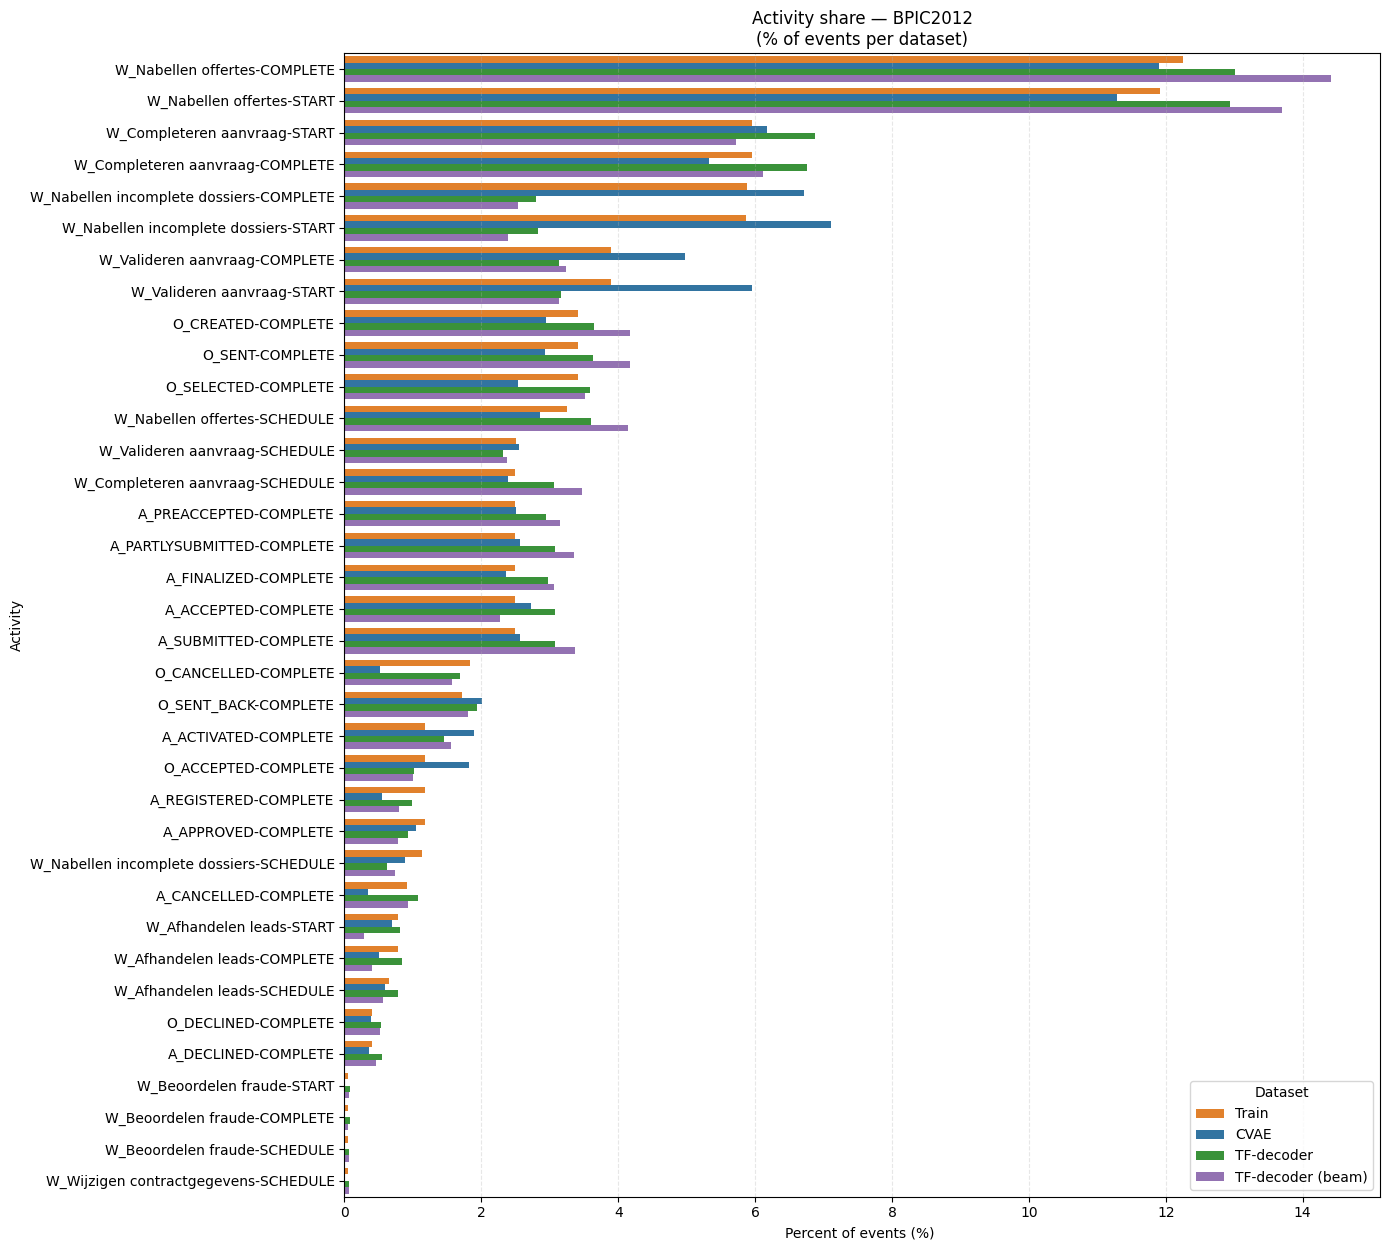

In [12]:
# ---------- Helpers ----------
def _read_csv_any(path: str) -> pd.DataFrame:
    for sep in [';', ',']:
        try:
            return pd.read_csv(path, sep=sep)
        except Exception:
            continue
    raise ValueError(f"Failed to read CSV with ';' or ',' : {path}")


def _collect_activity_counts_from_folder(folder: str, pattern: str = 'gen*.csv') -> pd.Series:
    if not os.path.exists(folder):
        print(f"Generated folder missing: {folder}")
        return pd.Series(dtype=int)
    files = sorted(glob.glob(os.path.join(folder, pattern)))
    if not files:
        files = sorted(glob.glob(os.path.join(folder, '*.csv')))
    counts = {}
    for f in files:
        try:
            df = _read_csv_any(f)
            # Reuse schema normalizer from previous cell if available
            if '_unify_schema' in globals():
                df = _unify_schema(df)
            if 'concept:name' in df.columns:
                vc = df['concept:name'].value_counts()
                for k, v in vc.items():
                    counts[k] = counts.get(k, 0) + int(v)
        except Exception:
            continue
    return pd.Series(counts, dtype=int).sort_index()


# ---------- Build counts ----------
# TEST (will be dropped from plot later if present)
test_df = _read_test_csv(data['test']) if 'test' in data else pd.DataFrame()
if len(test_df) > 0 and '_unify_schema' in globals():
    test_df = _unify_schema(test_df)

counts = {}
if len(test_df) > 0:
    counts['TEST'] = test_df['concept:name'].value_counts().sort_index()

# TRAIN (use already loaded train_df if available, otherwise attempt to load)
_train_df_candidate = None
try:
    if 'train_df' in globals() and isinstance(train_df, pd.DataFrame) and len(train_df) > 0:
        _train_df_candidate = train_df
    elif '_load_train_from_any_model' in globals():
        _train_df_candidate = _load_train_from_any_model(data)
except Exception:
    _train_df_candidate = None

if _train_df_candidate is None or len(_train_df_candidate) == 0:
    raise RuntimeError("No TRAIN data available; cannot build train-based comparison plot.")
if '_unify_schema' in globals():
    _train_df_candidate = _unify_schema(_train_df_candidate)
counts['TRAIN'] = _train_df_candidate['concept:name'].value_counts().sort_index()

# Generated models if present in the selected dataset dict
for key in ['gen_cvae', 'gen_flow', 'gen_flow_beam']:
    if key in data:
        counts[key] = _collect_activity_counts_from_folder(data[key])

# Combine into one DataFrame with union of activities
all_index = pd.Index([])
for s in counts.values():
    all_index = all_index.union(s.index)

comb = pd.DataFrame(index=all_index)
for name, s in counts.items():
    comb[name] = s
comb = comb.fillna(0).astype(int)

# Drop TEST; keep TRAIN + generated only
comb = comb.drop(columns=['TEST'], errors='ignore')

# Sort/limit uses TRAIN as reference now
TOP_N = 60  # adjust to see more/less

# Report activities not generated per model (zeros) for generated datasets only
for col in [c for c in comb.columns if c != 'TRAIN']:
    missing = comb.index[comb[col] == 0]
    if len(missing):
        print(f"Activities NOT generated by {col}: {len(missing)}")
        # Print a short preview to avoid overwhelming output
        print(list(missing[:20]))

# ---------- Convert to percentages (% of all events per dataset) ----------
col_sums = comb.sum(axis=0)
col_sums_safe = col_sums.replace(0, np.nan)
comb_pct = comb.divide(col_sums_safe, axis=1) * 100.0

# Sort by TRAIN percentage and limit to TOP_N
sort_ref = 'TRAIN' if 'TRAIN' in comb_pct.columns else comb_pct.columns[0]
comb_sorted = comb_pct.sort_values(by=sort_ref, ascending=False)
if TOP_N is not None:
    comb_sorted = comb_sorted.head(TOP_N)

# ---------- Plot: Horizontal grouped bars (percentages) with min visible floor ----------
MIN_VISIBLE_PCT = 0.05  # show tiny non-zero shares at least as 0.05% so bars are visible
long_df = comb_sorted.reset_index().melt(id_vars='index', var_name='Dataset', value_name='Percent')
long_df = long_df.rename(columns={'index': 'Activity'})
# Ensure consistent Dataset order
cat_order = [c for c in ['TRAIN', 'gen_cvae', 'gen_flow', 'gen_flow_beam'] if c in long_df['Dataset'].unique()]
long_df['Dataset'] = pd.Categorical(long_df['Dataset'], categories=cat_order, ordered=True)
# Floor tiny non-zero values for plotting visibility (keep 0 exactly 0)
long_df['PlotPercent'] = np.where((long_df['Percent'] > 0) & (long_df['Percent'] < MIN_VISIBLE_PCT), MIN_VISIBLE_PCT, long_df['Percent'])

height = max(6, 0.35 * len(comb_sorted))
plt.figure(figsize=(14, height))
palette = {
    'TRAIN': "#ff7f0e",
    'gen_cvae': '#1f77b4',
    'gen_flow': '#2ca02c',
    'gen_flow_beam': '#9467bd'
}
ax = sns.barplot(
    data=long_df,
    y='Activity', x='PlotPercent', hue='Dataset', orient='h',
    palette=[palette.get(k, None) for k in cat_order]
)
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_title(f"Activity share — {dataset_name.upper()}\n(% of events per dataset)")
ax.set_xlabel('Percent of events (%) ')
ax.set_ylabel('Activity')
# Remap legend labels to friendly names
legend_map = {
    'TRAIN': 'Train',
    'gen_cvae': 'CVAE',
    'gen_flow': 'TF-decoder',
    'gen_flow_beam': 'TF-decoder (beam)'
}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [legend_map.get(l, l) for l in labels], title='Dataset', loc='lower right')
plt.tight_layout()

# Save figure only in dataset-specific folder
out_root = os.path.abspath(os.path.join('..', 'output')) if os.path.basename(os.getcwd()) == 'notebooks' else os.path.join('output')
dataset_dir = os.path.join(out_root, dataset_name.lower())
os.makedirs(dataset_dir, exist_ok=True)
fig_path = os.path.join(dataset_dir, f'activity_frequency_{dataset_name}_hbar_pct.pdf')
plt.savefig(fig_path, format='pdf', bbox_inches='tight')

print(f"Saved activity frequency comparison (percent) to: {fig_path}")

# Show table as cell output (percentages)
comb_sorted